# Deep Q-Learning Project 1


In [1]:
from unityagents import UnityEnvironment
import numpy as np

import random
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

import pickle
import matplotlib.pyplot as plt
import os


from matplotlib import colors
from IPython.display import display, clear_output


%matplotlib notebook

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cwd = os.getcwd()

In [2]:
# For running on different machines, update this line according to 
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
# number of actions
action_size = brain.vector_action_space_size


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pdb
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, hidden_layers = (64,32), drop_p = 0.2):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.hidden_layers = nn.ModuleList([nn.Linear(state_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], action_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        


    def forward(self, x):
        """Build a network that maps state -> action values."""
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)
        
        return self.output(x)


In [19]:
import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim
import pdb

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
TAU = 1e-3              # for soft update of target parameters
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed, hidden_layers, drop_p, gamma, LR, plotting = False):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.layers = len(hidden_layers)
        self.gamma = gamma
            
        # Q-Network
        
        self.qnetwork_local = QNetwork(state_size, action_size, seed, hidden_layers, drop_p).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed, hidden_layers, drop_p).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        
        
        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
            

        self.start_weight = []
        for layer in self.qnetwork_local.hidden_layers:
            self.start_weight.append(layer.weight.cpu().detach().numpy())

        self.start_weight.append(self.qnetwork_local.output.weight.cpu().detach().numpy())

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences)
                

    def act(self, state, eps=1):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        #pdb.set_trace()
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            
    def init_vis():
        
        self.fig = plt.figure(figsize=(20,10))

        self.axs=[]
        for i in range(1,self.layers+2):
            self.axs.append(self.fig.add_subplot(1,self.layers+1, i))
            
    def visualize(self, colorbar=False):
        """
        Visualize weights of all layers
        
        """
        
        i=0;
        images = []
        for layer in self.qnetwork_local.hidden_layers:
            self.axs[i].clear()
            weights = layer.weight.cpu().detach().numpy()
            images.append(self.axs[i].imshow((weights-self.start_weight[i])**2))
            i+=1
            
        self.axs[-1].clear()    
        weights = self.qnetwork_local.output.weight.cpu().detach().numpy()
        images.append(self.axs[-1].imshow((weights-self.start_weight[-1])**2))
       
        if colorbar:
            self.fig.colorbar(images[0], ax=self.axs, orientation='vertical')

        clear_output(wait = True)

        display(self.fig)       



In [5]:

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
    
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [20]:
import time
import pdb
def dqn(agent, n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, plotting = False, saving = False):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    if plotting:
        agent.init_vis()
    
    
    for i_episode in range(1,n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0                                          # initialize the score
        start = time.time()
        for t in range(max_t):
            
            action = np.int32(agent.act(state,eps))            # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            
            if done:                                       # exit loop if episode finished
                break
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        print(f"\tTime per loop: {(time.time() - start)/3:.3f} seconds",end="")
        start = time.time()
        
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
        if plotting == True:
            agent.visualize()
            
        if np.mean(scores_window) > 13 and saving:
            print("\n Environment solved at episode {}".format(i_episode))
            torch.save(agent.qnetwork_local.state_dict(),'CheckpointAlpha.pth')
            agent.visualize(colorbar = True)
            plt.savefig(cwd+'\\Data\\CheckpointAlphaWeights.png')
            return scores
            
    return scores

In [7]:
def experiment(state_size=37, action_size=4, seed=0, parameter = None, hidden_layers=None, \
               hyper_parameters = None, episodes = 100, experiment_name = None, plotting = True, drop_p = 0, gamma = 0.99, LR= 5e-4):
    scores = []
    if hyper_parameters == None:
        for i in range(len(hidden_layers)):
            print('\nStarting Hidden Layers: '+ str(hidden_layers[i]))
            agent = Agent(state_size=37, action_size=4, seed=0, hidden_layers = hidden_layers[i], \
                          drop_p = drop_p, gamma = gamma, LR = LR)
            scores.append(dqn(n_episodes=episodes, agent = agent, plotting = plotting))
            f = open(cwd+'\\Data\\'  + experiment_name+'scores.pckl', 'wb')
            pickle.dump(scores, f)
            f.close() 
            f = open(cwd+'\\Data\\'  +experiment_name+'variable.pckl', 'wb')
            pickle.dump(hidden_layers[:i+1], f)
            f.close() 
        
    if hidden_layers == None:
        if parameter == 'LR':
            for i in range(len(hyper_parameters)):
                print('\nStarting Learning Rate Variable: '+ str(hyper_parameters[i]))
                agent = Agent(state_size=37, action_size=4, seed=0, hidden_layers = (32,), LR = hyper_parameters[i] )
                scores.append(dqn(n_episodes=episodes, agent = agent, plotting = plotting))
                f = open(cwd+'\\Data\\'  +experiment_name+'scores.pckl', 'wb')
                pickle.dump(scores, f)
                f.close() 
                f = open(cwd+'\\Data\\'  +experiment_name+'variable.pckl', 'wb')
                pickle.dump(hyper_parameters[:i+1], f)
                f.close() 
                
        if parameter == 'dropout':
            for i in range(len(hyper_parameters)):
                print('\nStarting Dropout Variable: '+ str(hyper_parameters[i]))
                agent = Agent(state_size=37, action_size=4, seed=0, hidden_layers = (32,), drop_p = hyper_parameters[i] )
                scores.append(dqn(n_episodes=episodes, agent = agent, plotting = plotting))
                f = open(cwd+'\\Data\\'  +experiment_name+'scores.pckl', 'wb')
                pickle.dump(scores, f)
                f.close() 
                f = open(cwd+'\\Data\\'  +experiment_name+'variable.pckl', 'wb')
                pickle.dump(hyper_parameters[:i+1], f)
                f.close() 
                
        if parameter == 'gamma':
            for i in range(len(hyper_parameters)):
                print('\nStarting Gamma Variable: '+ str(hyper_parameters[i]))
                agent = Agent(state_size=37, action_size=4, seed=0, hidden_layers = (32,), drop_p = drop_p,\
                              gamma = hyper_parameters[i], LR = LR)
                scores.append(dqn(n_episodes=episodes, agent = agent, plotting = plotting))
                f = open(cwd+'\\Data\\'  +experiment_name+'scores.pckl', 'wb')
                pickle.dump(scores, f)
                f.close() 
                f = open(cwd+'\\Data\\'  +experiment_name+'variable.pckl', 'wb')
                pickle.dump(hyper_parameters[:i+1], f)
                f.close() 

In [8]:

def plotExp(experiment_name, window = None):
    f = open(cwd+'\\Data\\'  + experiment_name +'scores.pckl', 'rb')
    scores = pickle.load(f)
    f.close() 

    f = open(cwd+'\\Data\\' + experiment_name +'variable.pckl', 'rb')
    fc = pickle.load(f)
    f.close() 
    if window == None:
        window = np.int32(np.rint(0.05*len(scores[0])))

    running_scores=[]
    for ep in scores:
        running_scores.append(np.convolve(ep, np.ones((window,))/window, mode='valid'))

    for ep in range(len(fc)):
        plt.plot(np.arange(len(running_scores[ep])), running_scores[ep], label=fc[ep])
    plt.legend() 
    plt.savefig(cwd+'\\Data\\' +experiment_name+'.png')
    plt.show()
    

## Experimenting with number of layers



Starting Hidden Layers: (32,)
Episode 100	Average Score: -0.02	Time per loop: 0.288 seconds
Episode 200	Average Score: 1.63	Time per loop: 0.292 secondss
Episode 300	Average Score: 5.13	Time per loop: 0.303 seconds
Episode 400	Average Score: 8.07	Time per loop: 0.302 seconds
Episode 500	Average Score: 9.89	Time per loop: 0.297 seconds

Starting Hidden Layers: (64, 32)
Episode 100	Average Score: 0.18	Time per loop: 0.330 seconds
Episode 200	Average Score: 0.20	Time per loop: 0.327 seconds
Episode 300	Average Score: 0.99	Time per loop: 0.335 seconds
Episode 400	Average Score: 2.38	Time per loop: 0.333 seconds
Episode 500	Average Score: 2.99	Time per loop: 0.336 seconds

Starting Hidden Layers: (128, 64, 32)
Episode 100	Average Score: 0.42	Time per loop: 0.359 seconds
Episode 200	Average Score: 1.49	Time per loop: 0.364 seconds
Episode 300	Average Score: 3.84	Time per loop: 0.391 seconds
Episode 400	Average Score: 5.24	Time per loop: 0.399 seconds
Episode 500	Average Score: 8.77	Time per

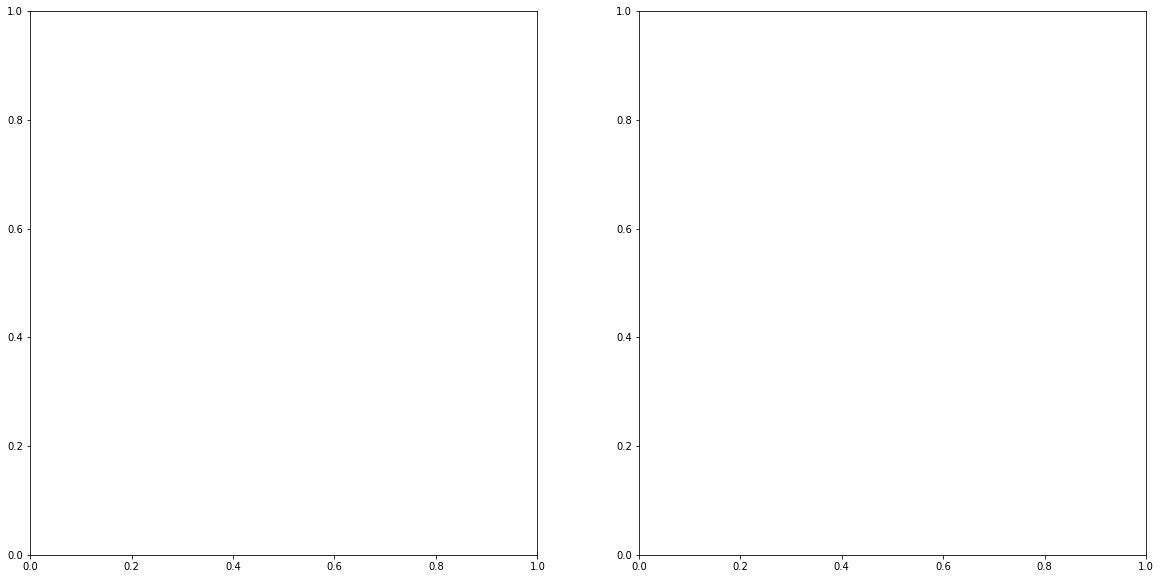

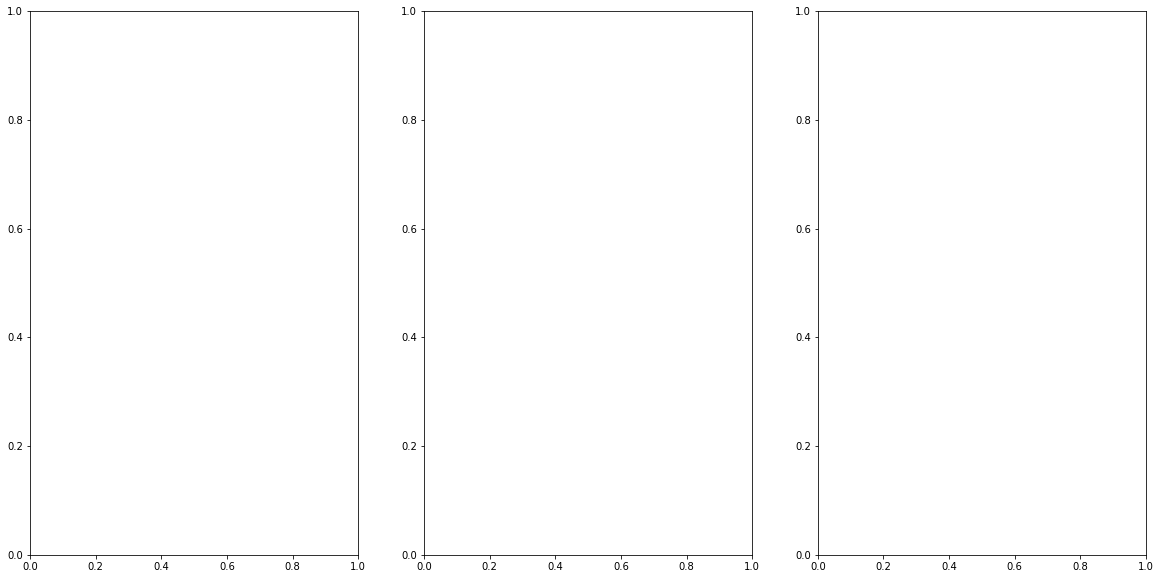

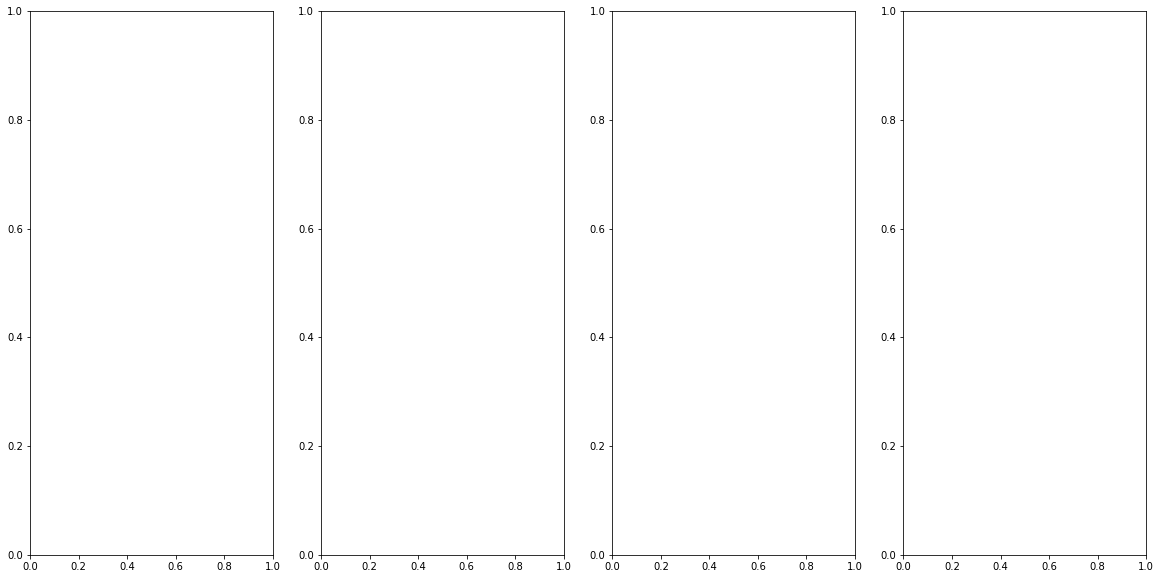

In [11]:
hidden_layers = [(32,),(64,32),(128,64,32)]
exname = 'HiddenLayerLengthComparison'
experiment(hidden_layers=hidden_layers, parameter = None, hyper_parameters = None,\
           episodes = 500, experiment_name = exname ,plotting = False, drop_p = 0.2, gamma = 0.8, LR = 5e-4)

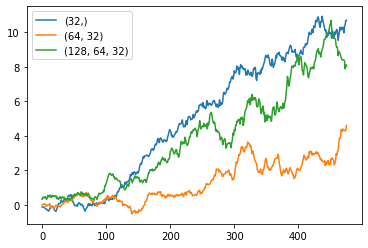

In [12]:
plotExp(exname)

## Experimenting with hyper parameters


Starting Gamma Variable: 0
Episode 100	Average Score: -0.01	Time per loop: 0.275 seconds
Episode 200	Average Score: 0.34	Time per loop: 0.274 secondss
Episode 300	Average Score: 0.51	Time per loop: 0.283 seconds
Episode 400	Average Score: 0.12	Time per loop: 0.297 seconds
Episode 500	Average Score: 0.23	Time per loop: 0.309 seconds

Starting Gamma Variable: 0.1
Episode 100	Average Score: 0.44	Time per loop: 0.275 seconds
Episode 200	Average Score: 0.71	Time per loop: 0.279 seconds
Episode 300	Average Score: 0.68	Time per loop: 0.281 seconds
Episode 400	Average Score: 1.03	Time per loop: 0.286 seconds
Episode 500	Average Score: 0.56	Time per loop: 0.287 seconds

Starting Gamma Variable: 0.2
Episode 100	Average Score: 0.02	Time per loop: 0.275 seconds
Episode 200	Average Score: 0.43	Time per loop: 0.279 seconds
Episode 300	Average Score: 1.08	Time per loop: 0.285 seconds
Episode 400	Average Score: 1.32	Time per loop: 0.285 seconds
Episode 500	Average Score: 1.52	Time per loop: 0.352 sec

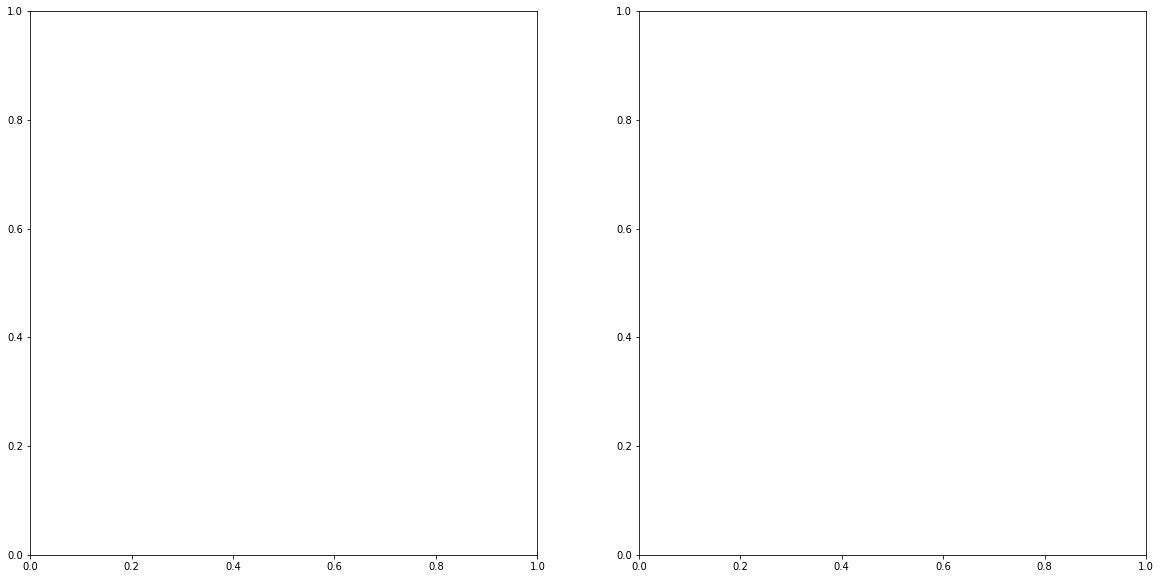

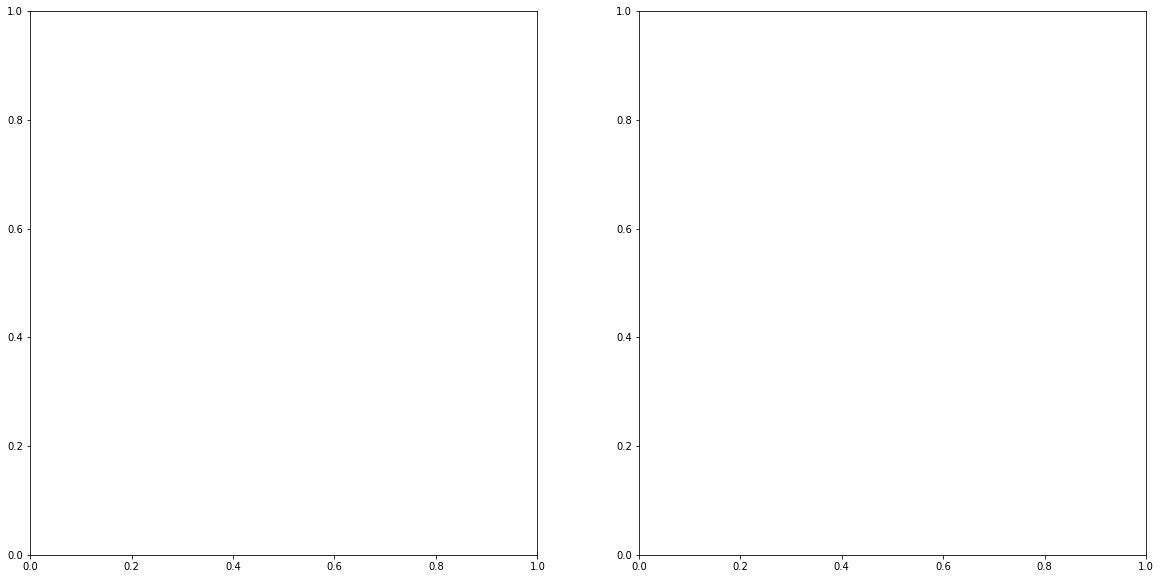

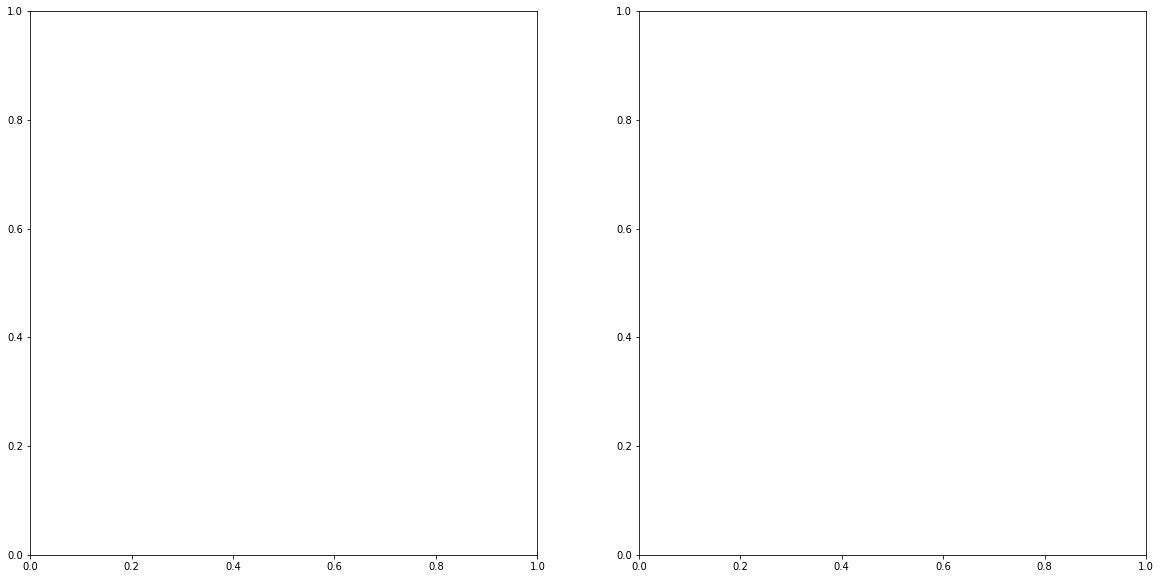

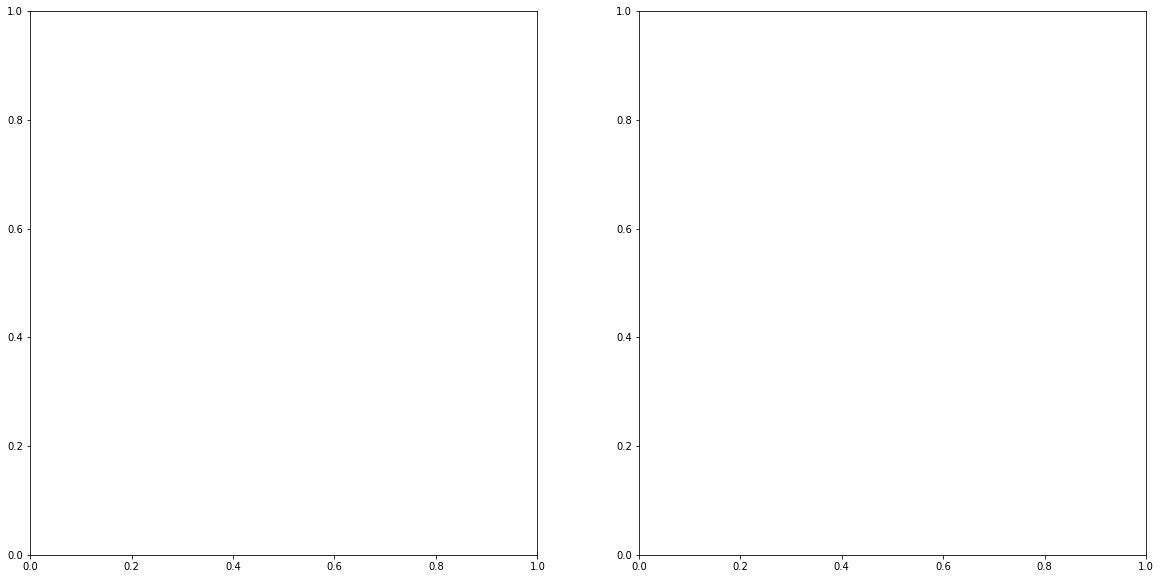

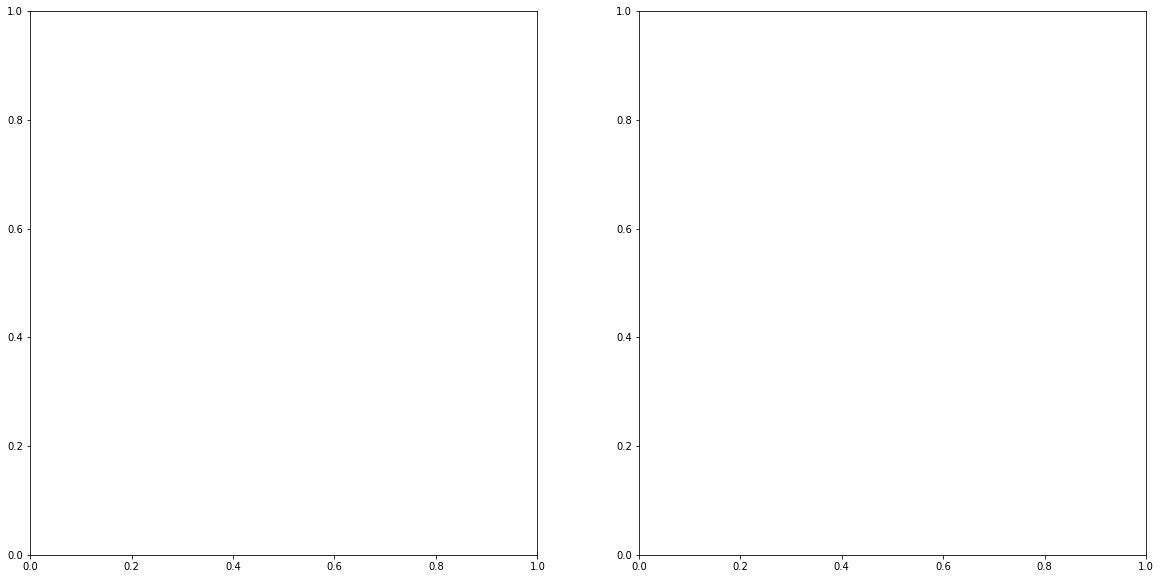

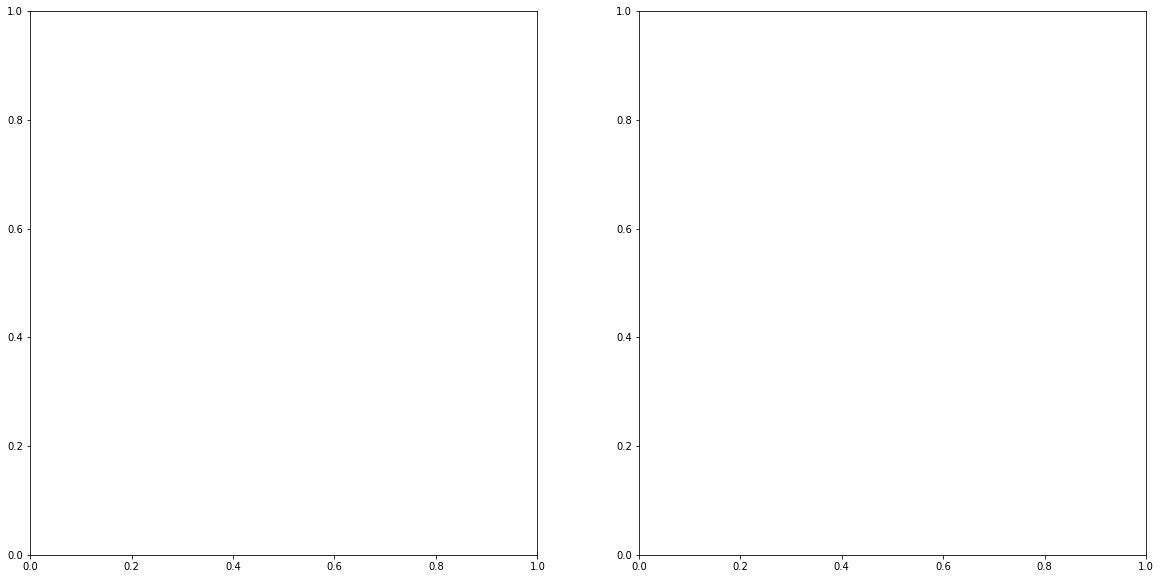

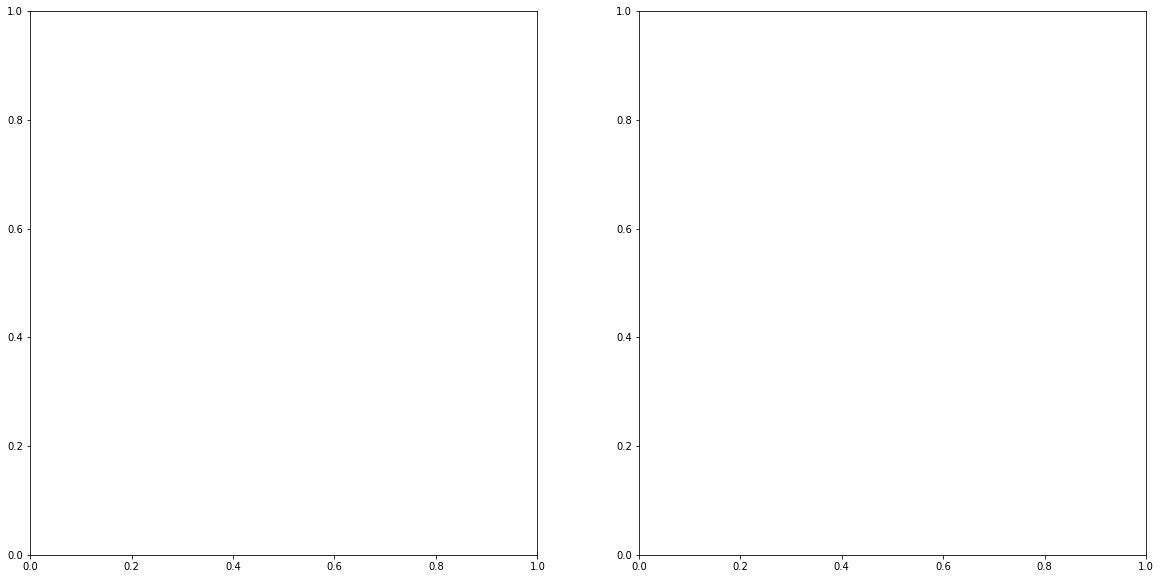

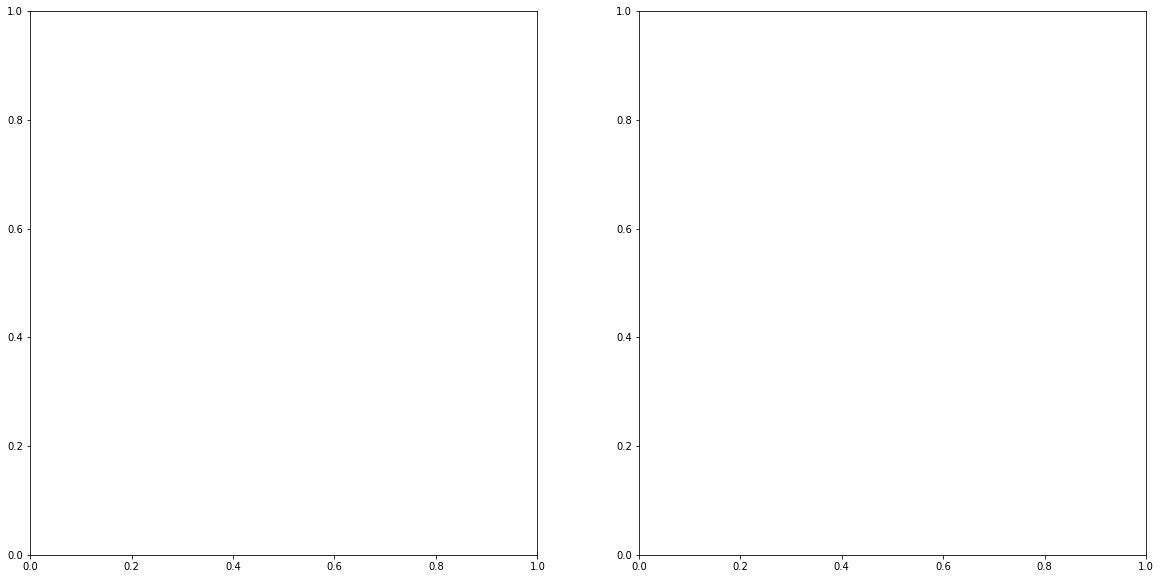

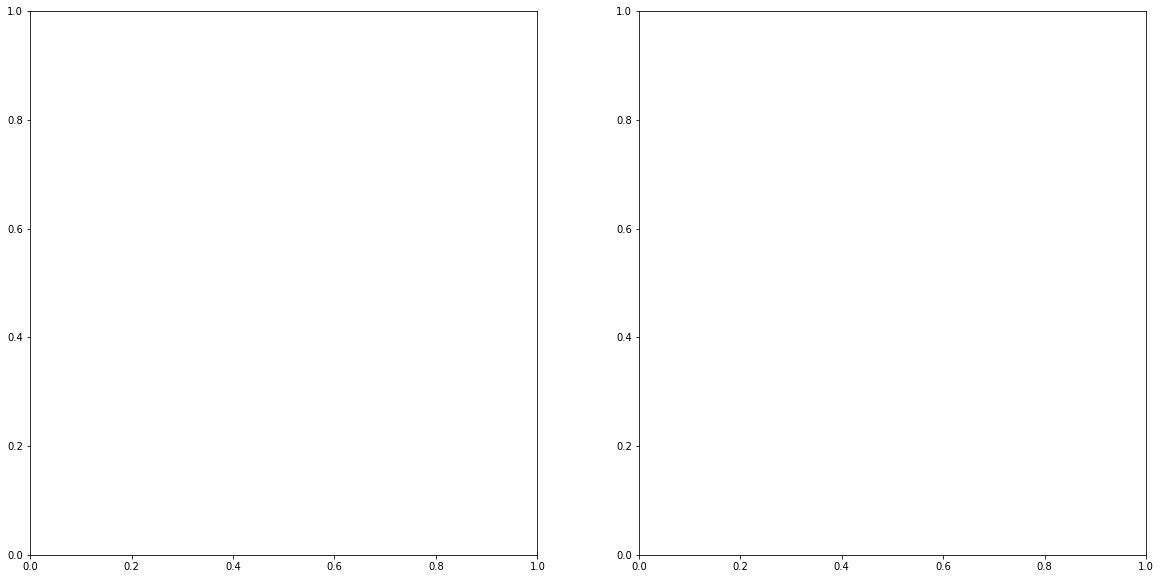

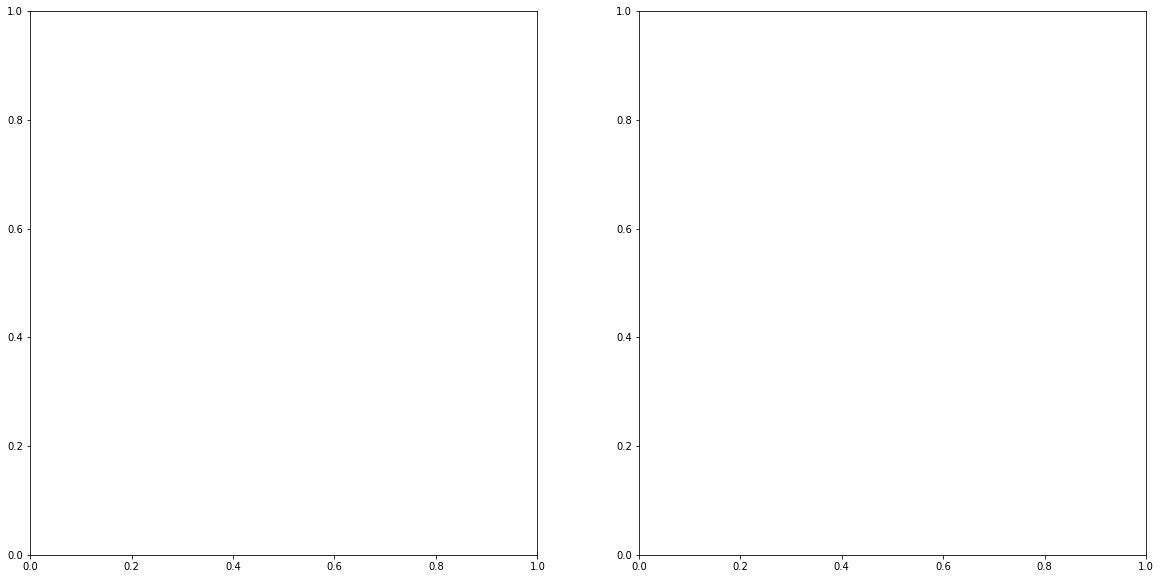

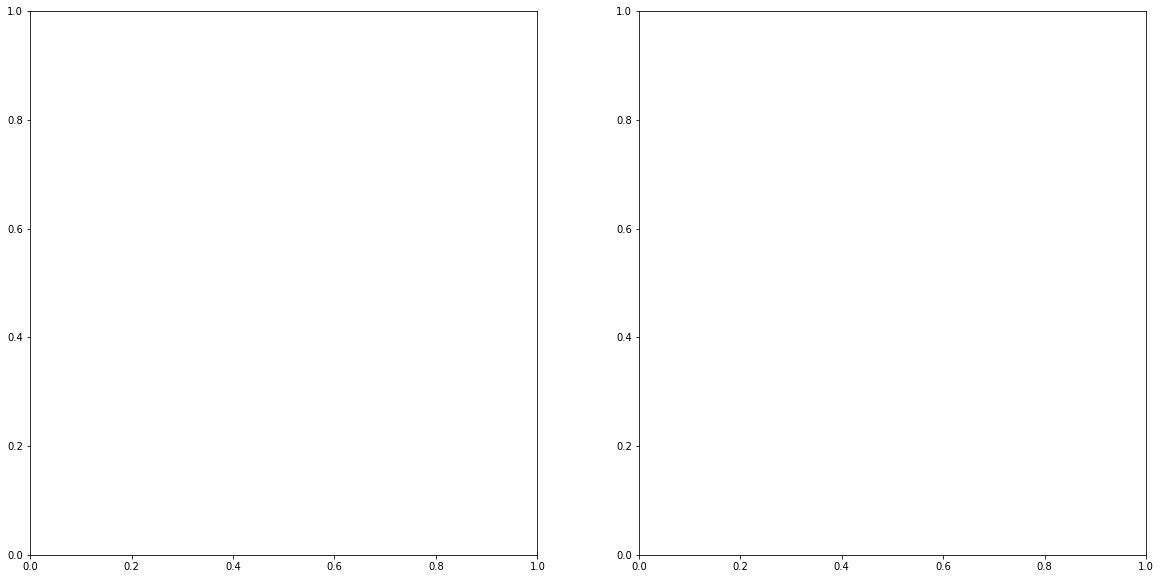

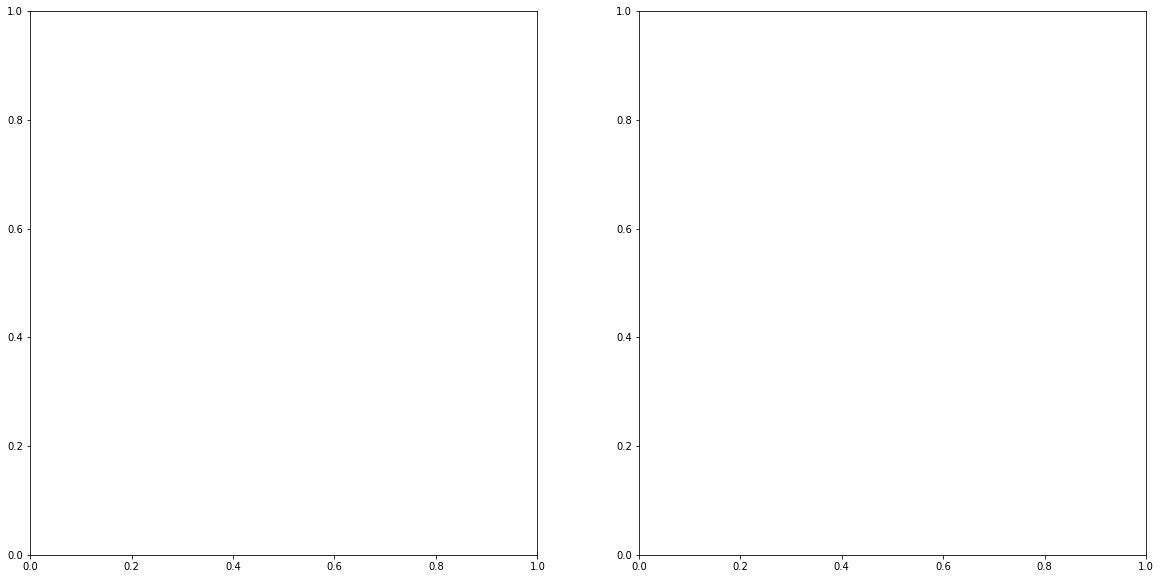

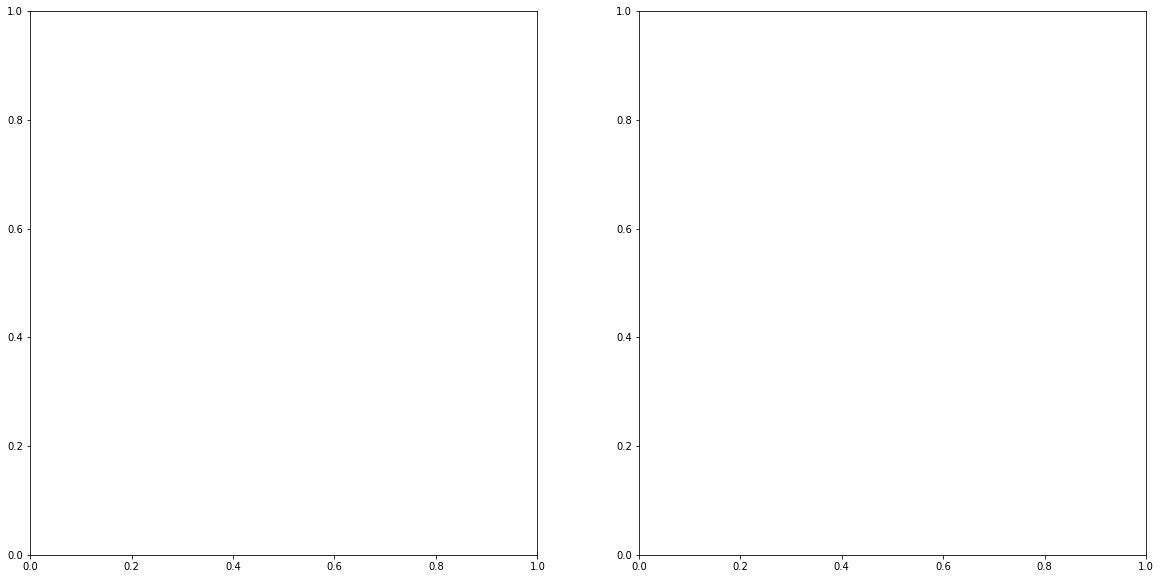

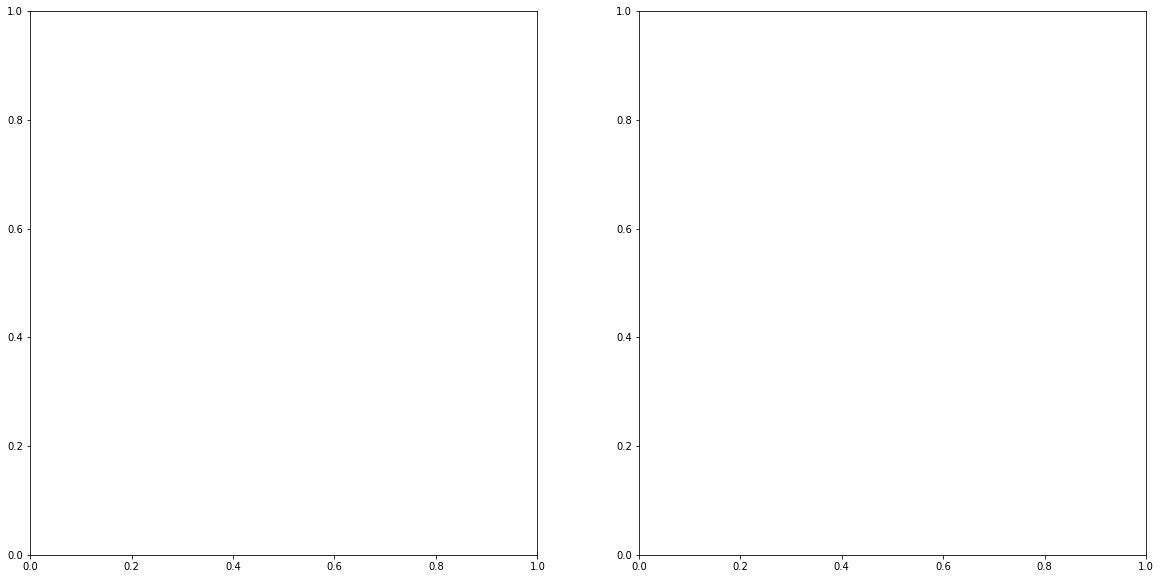

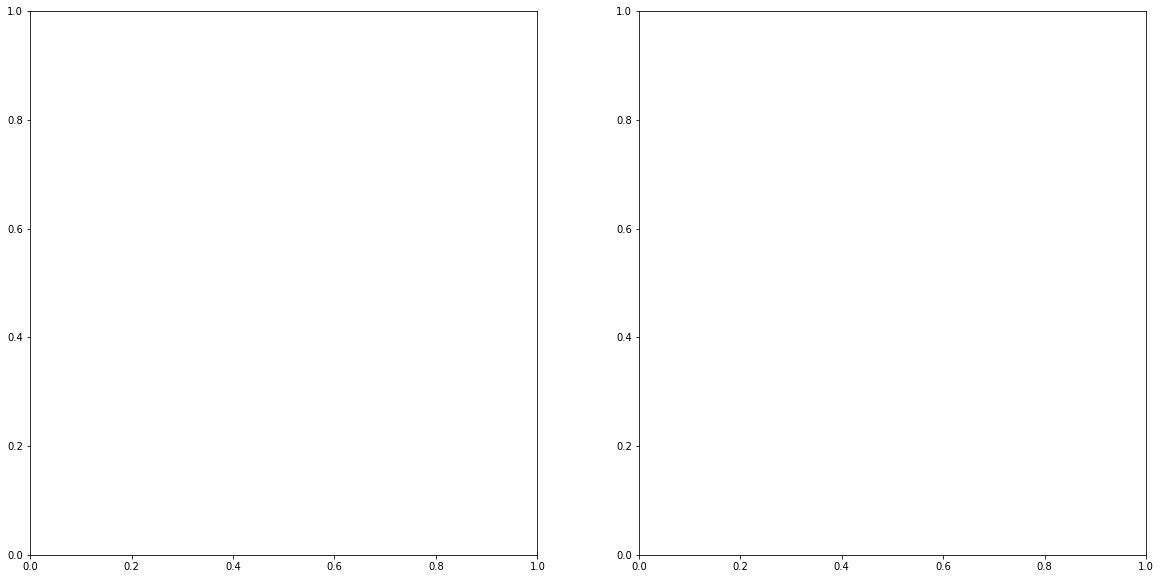

In [13]:
gamma = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.93, 0.95, 0.98, 0.99, 1.0]
exname = 'DifferentDiscountFactors'
experiment(hidden_layers=None, parameter = 'gamma', hyper_parameters = gamma,\
           episodes = 500, experiment_name = exname ,plotting = False, drop_p = 0, gamma = None)

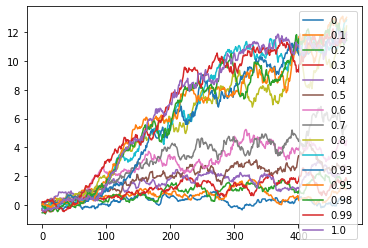

In [14]:
plotExp(exname)

# Optimal Agent


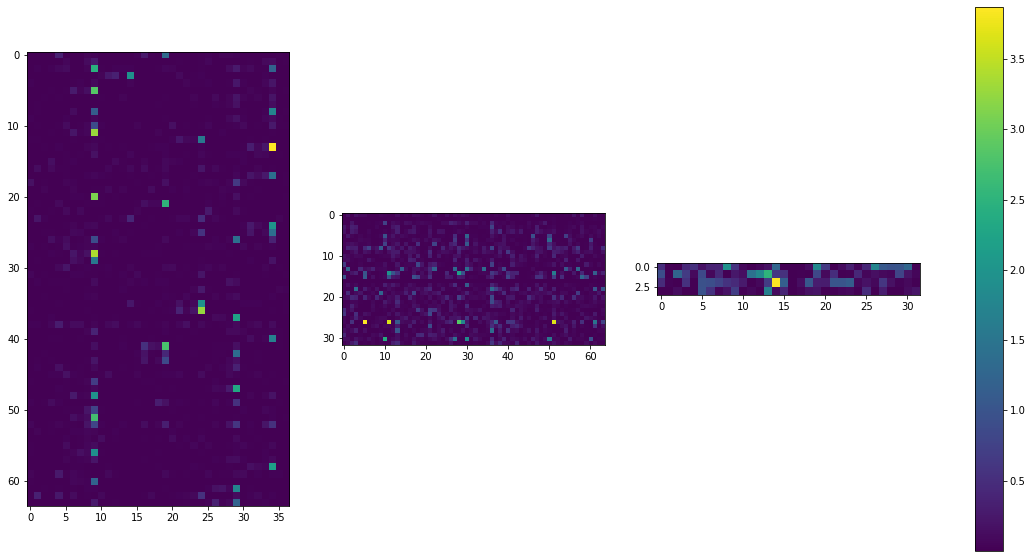

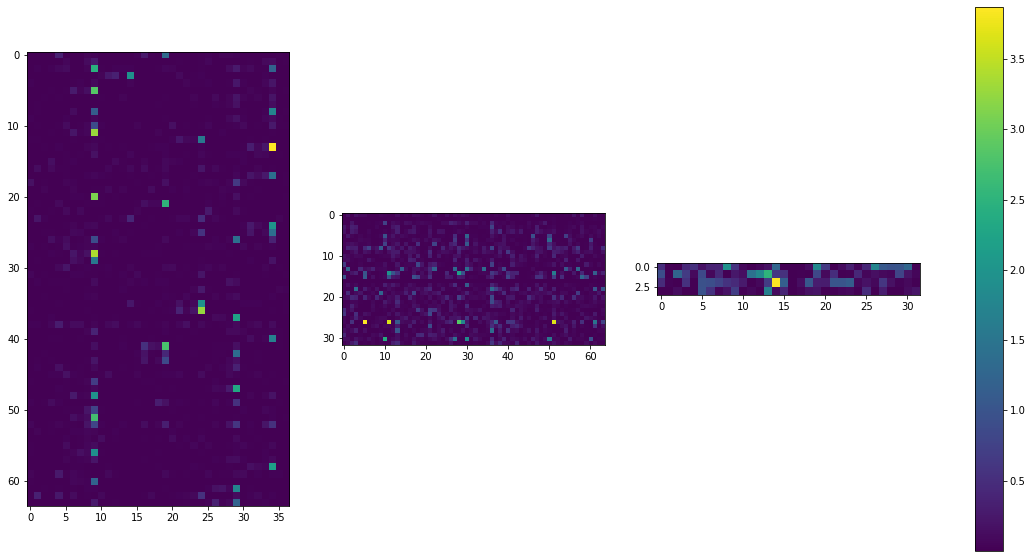

In [15]:
plotting = True
agent = Agent(state_size=37, action_size=4, seed=0, hidden_layers = (64,32), drop_p = 0.2, gamma = 0.99, LR = 5e-4, plotting = plotting)
scores = dqn(n_episodes=1000, agent = agent, plotting = plotting, saving = True )

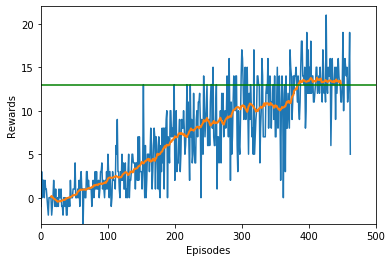

In [16]:
fig, ax = plt.subplots()
 

ax.plot(range(0,len(scores)),scores)
window = 30
running_scores=(np.convolve(scores, np.ones((window,))/window, mode='valid'))
x=range(int(window/2),int(len(running_scores)+window/2))
ax.plot(x,running_scores,'-',lw=2)
ax.plot(np.array([0,500]),np.array([13,13]),'g-')

ax.set_xlabel('Episodes')
ax.set_ylabel('Rewards')
ax.set_xlim((0, 500))
ax.set_ylim((-3, 22))


plt.savefig(cwd+'\\Data\\CheckpointAlphaRewards.png')
plt.show()


## Watching a trained agent

In [21]:

agent = Agent(state_size=37, action_size=4, seed=0, hidden_layers = (64,32), drop_p = 0.2, gamma = 0.99, LR = 5e-4)

agent.qnetwork_local.load_state_dict(torch.load('CheckpointAlpha.pth'))
agent.qnetwork_local.eval()

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
point = time.time()
for t in range(1000):    
    action = np.int32(agent.act(state,0))            # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state                     
    state = next_state                             # roll over the state to next time step
    done = env_info.local_done[0]
    if done:
        break
    

In [18]:
#Display all weights and biases from model
for name, param in agent.qnetwork_local.named_parameters():
    if param.requires_grad:
        print(name, param.data)

hidden_layers.0.weight tensor([[ 9.1665e-02, -1.1083e-02, -1.8983e-01,  ..., -2.5371e-02,
          1.5006e-02, -1.6857e-03],
        [ 2.7649e-02,  1.1761e-01,  3.6110e-02,  ...,  2.8487e-01,
         -2.1775e-03, -3.8974e-03],
        [ 1.0624e-01, -3.9845e-02,  1.4434e-01,  ..., -1.1154e+00,
         -8.9139e-02,  4.1480e-02],
        ...,
        [-8.9612e-04,  1.1444e-02, -3.8336e-03,  ...,  1.1832e-01,
         -7.6362e-03, -1.2764e-03],
        [ 9.0156e-02, -6.1138e-01,  9.8092e-03,  ..., -1.7255e-01,
         -2.4293e-02, -4.3975e-02],
        [-8.2121e-02, -1.2107e-01, -8.3710e-02,  ...,  1.1849e-01,
          7.6188e-03,  8.2198e-03]], device='cuda:0')
hidden_layers.0.bias tensor([ 0.1209, -0.1312, -0.1161, -0.0202,  0.0507, -0.0109, -0.1467,
         0.0055,  0.0407, -0.2415,  0.0804,  0.0907,  0.1203, -0.0134,
        -0.0898, -0.1437, -0.0455, -0.1134,  0.0172, -0.2215, -0.0869,
         0.0707, -0.1054, -0.0745, -0.1429,  0.1511, -0.0427, -0.2252,
         0.0802,  0.109

## Debugging Code

In [ ]:
import cProfile
agent = Agent(state_size=37, action_size=4, seed=0)
#cProfile.run('dqn(agent)')

In [ ]:
env.close()